In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import os
import sys
import copy
import time
import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')
from typing import List

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader

In [4]:
import matplotlib
# matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt 

matplotlib.rcParams['lines.linewidth'] = 1
matplotlib.rcParams['lines.markersize'] = 5

In [5]:
import math
import numpy as np
from PIL import Image

In [6]:
# https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data

# Load Fower102 Data

In [7]:
batch_size = 128
input_size = (224, 224, 3)
img_size = (32, 32, 3)

In [8]:
bg_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [9]:
bg_trainset = datasets.Flowers102('../../data', split='train', transform=bg_data_transforms['train'], download=True)
bg_trainloader = torch.utils.data.DataLoader(bg_trainset, batch_size=batch_size, shuffle=True, num_workers=0)

bg_valset = datasets.Flowers102('../../data', split='val', transform=bg_data_transforms['val'], download=True)
bg_valloader = torch.utils.data.DataLoader(bg_valset, batch_size=batch_size, shuffle=False, num_workers=0)

# Load Cifar10 Dataset

In [10]:
fg_data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    ]),
}

In [11]:
fg_trainset = datasets.CIFAR10('../../data', train=True, transform=fg_data_transforms['train'], download=True)
fg_trainloader = torch.utils.data.DataLoader(fg_trainset, batch_size=batch_size, shuffle=True, num_workers=0)

fg_valset = datasets.CIFAR10('../../data', train=False, transform=fg_data_transforms['val'], download=True)
fg_valloader = torch.utils.data.DataLoader(fg_valset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


# Prepare

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([128, 3, 224, 224])


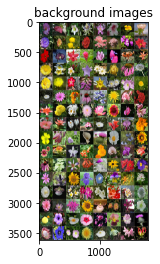

In [13]:
# Get a batch of training data
inputs, classes = next(iter(bg_trainloader))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="background images")

torch.Size([128, 3, 32, 32])


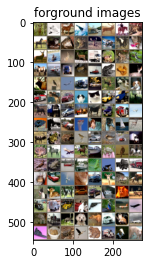

In [14]:
# Get a batch of training data
inputs, classes = next(iter(fg_trainloader))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title="forground images")

In [15]:
bg_data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
    ]),
}

In [16]:
bg_trainset = datasets.Flowers102('../../data', split='train', transform=bg_data_transforms['train'], download=True)
bg_trainloader = torch.utils.data.DataLoader(bg_trainset, batch_size=batch_size, shuffle=True, num_workers=0)

bg_valset = datasets.Flowers102('../../data', split='val', transform=bg_data_transforms['val'], download=True)
bg_valloader = torch.utils.data.DataLoader(bg_valset, batch_size=batch_size, shuffle=False, num_workers=0)

bg_testset = datasets.Flowers102('../../data', split='test', transform=bg_data_transforms['val'], download=True)
bg_testloader = torch.utils.data.DataLoader(bg_testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [17]:
fg_data_transforms = {
    'train': transforms.Compose([
    ]),
    'val': transforms.Compose([
    ]),
}

In [18]:
fg_trainset = datasets.CIFAR10('../../data', train=True, transform=fg_data_transforms['train'], download=True)
fg_trainloader = torch.utils.data.DataLoader(fg_trainset, batch_size=batch_size, shuffle=True, num_workers=0)

fg_valset = datasets.CIFAR10('../../data', train=False, transform=fg_data_transforms['val'], download=True)
fg_valloader = torch.utils.data.DataLoader(fg_valset, batch_size=batch_size, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
for img, label in bg_trainset:
    print(type(img), label, img.size, img.getextrema())
    break

<class 'PIL.Image.Image'> 0 (224, 224) ((1, 210), (2, 211), (0, 227))


In [20]:
for img, label in fg_trainset:
    print(type(img), label, img.size, img.getextrema())
    break

<class 'PIL.Image.Image'> 6 (32, 32) ((0, 255), (0, 253), (0, 235))


# Random Background Fixed Position

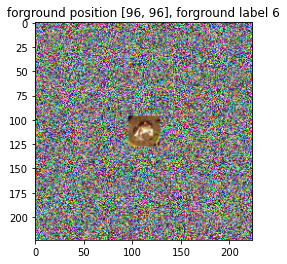

In [27]:
for img, label in fg_trainset:
    forground = np.array(img)
    fg_label = label
    background = np.random.randint(0, 256, input_size, dtype=np.uint8)
    pos = [32*3, 32*3]
    background[pos[0]:pos[0]+32, pos[1]:pos[1]+32] = forground
    fig = plt.figure()
    plt.imshow(background)
    plt.title(f'forground position {pos}, forground label {fg_label}')
    plt.show()
    plt.close(fig)
    break

# Random Background Random Position

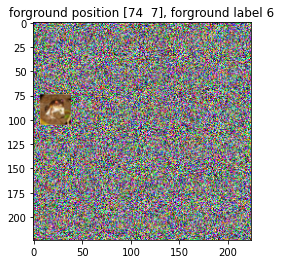

In [28]:
for img, label in fg_trainset:
    forground = np.array(img)
    fg_label = label
    background = np.random.randint(0, 256, input_size, dtype=np.uint8)
    pos = np.random.randint(0, 32*6, 2, dtype=np.uint8)
    background[pos[0]:pos[0]+32, pos[1]:pos[1]+32] = forground
    fig = plt.figure()
    plt.imshow(background)
    plt.title(f'forground position {pos}, forground label {fg_label}')
    plt.show()
    plt.close(fig)
    break

# Structural Background Fixed Position

(224, 224, 3) <class 'int'> 6 <class 'int'> 73


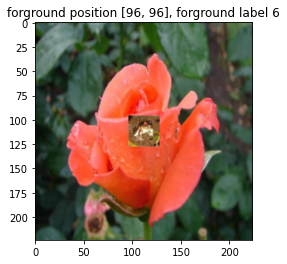

In [35]:
for img, label in fg_trainset:
    forground = np.array(img)
    fg_label = label
    bg_id = np.random.randint(0, len(bg_trainset))
    background = np.array(copy.deepcopy(bg_trainset[bg_id][0]))
    bg_label = bg_trainset[bg_id][1]
    print(background.shape, type(fg_label), fg_label, type(bg_label), bg_label)
    pos = [32*3, 32*3]
    background[pos[0]:pos[0]+32, pos[1]:pos[1]+32] = forground
    fig = plt.figure()
    plt.imshow(background)
    plt.title(f'forground position {pos}, forground label {fg_label}')
    plt.show()
    plt.close(fig)
    break

# Structural Background Random Position

(224, 224, 3) <class 'int'> 6 <class 'int'> 59


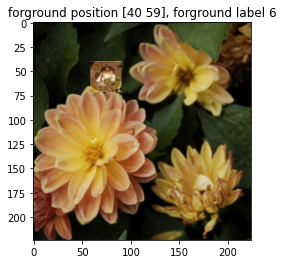

In [36]:
for img, label in fg_trainset:
    forground = np.array(img)
    fg_label = label
    bg_id = np.random.randint(0, len(bg_trainset))
    background = np.array(copy.deepcopy(bg_trainset[bg_id][0]))
    bg_label = bg_trainset[bg_id][1]
    print(background.shape, type(fg_label), fg_label, type(bg_label), bg_label)
    pos = np.random.randint(0, 32*6, 2, dtype=np.uint8)
    background[pos[0]:pos[0]+32, pos[1]:pos[1]+32] = forground
    fig = plt.figure()
    plt.imshow(background)
    plt.title(f'forground position {pos}, forground label {fg_label}')
    plt.show()
    plt.close(fig)
    break

In [46]:
idx = 5000
f'{idx:04d}'

'5000'